In [1]:
# you need to first run `/model_fitting/cnn_popluation/sub.py`

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

In [4]:
from itertools import product

In [5]:
from maskcnn import postprocess, training_aux_wrapper
from tang_jcompneuro.cell_stats import compute_ccmax
from tang_jcompneuro.cell_classification import get_ready_to_use_classification
from tang_jcompneuro import dir_dictionary
import os.path

In [6]:
class_dict_mka = get_ready_to_use_classification()['MkA_Shape']

In [7]:
opt_names = list(training_aux_wrapper.all_opt_configs.keys())

In [8]:
opt_names

['poisson_10000',
 'mse_10000',
 'poisson_1000',
 'mse_1000',
 'poisson_100',
 'mse_100',
 'poisson_10',
 'mse_10',
 'poisson_1',
 'mse_1']

In [9]:
arch_names = list(training_aux_wrapper.gen_all_arch_config('MkA_Shape', 'all', 'OT').keys())

In [10]:
arch_names

['5_3_100',
 '7_3_100',
 '9_3_100',
 '11_3_100',
 '13_3_100',
 '5_3_75',
 '7_3_75',
 '9_3_75',
 '11_3_75',
 '13_3_75',
 '5_3_50',
 '7_3_50',
 '9_3_50',
 '11_3_50',
 '13_3_50',
 '5_3_25',
 '7_3_25',
 '9_3_25',
 '11_3_25',
 '13_3_25']

In [11]:
# for each arch, report the one with best test performance (so it's overfitting)
# I just want to see how good they can be.
def collect_one_model_performance(neuron_subset):
    # return the one with highest mean ccnorm_5^2 score.
    ccmax_this = compute_ccmax('MkA_Shape', 'all', 5)
    assert ccmax_this.shape == class_dict_mka[neuron_subset].shape
    ccmax_this = ccmax_this[class_dict_mka[neuron_subset]]
    
    dt_all_this = []
    
    # ok. just load
    for arch_name, opt_name in product(arch_names, opt_names):
        print(arch_name, opt_name)
        corr_this_1 = postprocess.load_model_performance('MkA_Shape', 'all', neuron_subset, 0, arch_name, opt_name)['corr']
        assert corr_this_1.shape == ccmax_this.shape
        corr_this_1 /= ccmax_this
        corr_this_2 = postprocess.load_model_performance('MkA_Shape', 'all', neuron_subset, 1, arch_name, opt_name)['corr']
        assert corr_this_2.shape == ccmax_this.shape
        corr_this_2 /= ccmax_this

        dt_all_this.append({
            'arch': arch_name,
            'opt': opt_name,
            'score': ((corr_this_1**2 + corr_this_2**2)/2).mean(),
            'score_raw': (corr_this_1**2 + corr_this_2**2)/2
        })
    dt_all_this = pd.DataFrame(dt_all_this, columns=['arch', 'opt', 'score', 'score_raw'])
    dt_all_this = dt_all_this.set_index(['arch', 'opt'], verify_integrity=True).sort_index()
    return dt_all_this

In [12]:
dir_to_save = os.path.join(dir_dictionary['analyses'], 'cnn_population')
os.makedirs(dir_to_save, exist_ok=True)
HO_file = os.path.join(dir_to_save, 'MkA_HO.hdf5')
if not os.path.exists(HO_file):
    HO_perm = collect_one_model_performance('HO')
    HO_perm.to_pickle(HO_file)
else:
    HO_perm = pd.read_pickle(HO_file)
    
    
OT_file = os.path.join(dir_to_save, 'MkA_OT.hdf5')
if not os.path.exists(OT_file):
    OT_perm = collect_one_model_performance('OT')
    OT_perm.to_pickle(OT_file)
else:
    OT_perm = pd.read_pickle(OT_file)

In [13]:
HO_perm['score_raw'].loc['9_3_100', 'poisson_1000']

array([ 0.66961634,  0.59301853,  0.78726256,  0.05290014,  0.62058783,
        0.68583453,  0.75300443,  0.36205482,  0.41402847,  0.46156543,
        0.12924938,  0.09157769,  0.09324196,  0.15089044,  0.15013252,
        0.3891297 ,  0.28823233,  0.32672566,  0.41614598,  0.52761251,
        0.17705193,  0.31535769,  0.7542479 ,  0.28710347,  0.5854547 ,
        0.44483882,  0.27302051,  0.67459035,  0.52598143,  0.62328827,
        0.63079226,  0.18472818,  0.49486777,  0.64296293,  0.42532167,
        0.36964256,  0.24022052,  0.49116868,  0.68835723,  0.7151764 ,
        0.1238791 ,  0.53794873,  0.38513222,  0.36721492,  0.50245035,
        0.40291861,  0.17998391,  0.04683735,  0.48721394,  0.63716638,
        0.53333282,  0.58044839,  0.53488201,  0.22123891,  0.18923482,
        0.08651588,  0.66513276,  0.73409814,  0.63035715,  0.65103972,
        0.37256134,  0.62456357,  0.33638692,  0.28039998,  0.38023907,
        0.11512458,  0.5099768 ,  0.30893689,  0.20705688,  0.01

In [14]:
HO_perm['score'].unstack('opt')
# basically nothing good. just pick one example should be fine.

opt,mse_1,mse_10,mse_100,mse_1000,mse_10000,poisson_1,poisson_10,poisson_100,poisson_1000,poisson_10000
arch,,,,,,,,,,
11_3_100,0.399199,0.410067,0.419266,0.410759,0.361716,0.409338,0.408817,0.411599,0.416296,0.374328
11_3_25,0.310795,0.303171,0.321143,0.321133,0.286965,0.307785,0.307979,0.319969,0.336827,0.309618
11_3_50,0.369067,0.379955,0.383386,0.386910,0.338444,0.371989,0.375304,0.389621,0.381568,0.357645
11_3_75,0.397475,0.395505,0.409628,0.402732,0.357568,0.402417,0.395260,0.390011,0.418665,0.366693
13_3_100,0.421422,0.425573,0.422722,0.425343,0.360856,0.416911,0.420422,0.426260,0.428312,0.377287
13_3_25,0.318987,0.308643,0.326237,0.322736,0.279274,0.316925,0.318703,0.319765,0.341867,0.318486
13_3_50,0.378448,0.382162,0.384678,0.377676,0.333847,0.392466,0.384741,0.392768,0.387769,0.353227
13_3_75,0.395974,0.398413,0.407364,0.406249,0.351292,0.414627,0.415396,0.406563,0.411332,0.374861
5_3_100,0.258368,0.273673,0.308568,0.335048,0.310052,0.262647,0.266401,0.254096,0.359279,0.320075


In [15]:
OT_perm['score'].unstack('opt')

opt,mse_1,mse_10,mse_100,mse_1000,mse_10000,poisson_1,poisson_10,poisson_100,poisson_1000,poisson_10000
arch,,,,,,,,,,
11_3_100,0.484178,0.486279,0.523496,0.522604,0.453815,0.490168,0.500603,0.490377,0.516349,0.471477
11_3_25,0.411236,0.415890,0.425472,0.420416,0.372857,0.417995,0.413199,0.421729,0.427902,0.398613
11_3_50,0.479872,0.475170,0.478429,0.475144,0.422511,0.476123,0.464528,0.472762,0.470014,0.443042
11_3_75,0.502370,0.496062,0.506977,0.501350,0.442766,0.487234,0.481382,0.496623,0.504132,0.461329
13_3_100,0.519860,0.510110,0.520724,0.511230,0.465207,0.514292,0.515988,0.521773,0.521024,0.479272
13_3_25,0.414743,0.417628,0.411659,0.411245,0.375285,0.418520,0.415134,0.423411,0.421938,0.387691
13_3_50,0.475380,0.466297,0.473827,0.475775,0.426995,0.470828,0.475008,0.475671,0.484725,0.443482
13_3_75,0.501945,0.502512,0.497516,0.494683,0.447089,0.499774,0.505949,0.491439,0.504136,0.456436
5_3_100,0.395952,0.399841,0.386465,0.416588,0.419087,0.382637,0.398809,0.441832,0.437250,0.404659


In [16]:
# also get baseline performance.
import numpy as np
import pandas as pd
from tang_jcompneuro.model_fitting_postprocess import load_data_generic

def check_all(squared, score_col_name):
    models_to_examine = [
        ('cnn', 'b.9'),
    ] # TODO should make this a ordered dict.
      # so that it will be easier to collect best val model for each model class.
    
    return load_data_generic(models_to_examine, load_naive=False, metric='ccnorm_5', squared=squared,
                            score_col_name=score_col_name,datasets_to_check=('MkA_Shape',),
                            subsets_to_check=('all',))
df_all_cc2 = check_all(squared=True, score_col_name='cc2').xs(100, level='percentage').sort_index()
assert df_all_cc2.shape == (1,1)
base_perf_dict = df_all_cc2.values[0,0]

MkA_Shape all


In [17]:
# fetch 9_3_100

In [18]:
from tang_jcompneuro.plotting import show_one_basic, show_perf_vs_size
from tang_jcompneuro import dir_dictionary
import os.path


In [19]:
# magic numbers here follow
# https://github.com/leelabcnbc/tang_jcompneuro/blob/master/thesis_plots/v1_fitting/results_glm_opt_detailed.ipynb
def draw_one_stuff():
    image_subset_and_neuron_subset_list = (('all', 'OT'), ('all', 'HO'))
    num_panel = len(image_subset_and_neuron_subset_list)
    
    plt.close('all')
    fig, axes = plt.subplots(1, num_panel, sharex=True, sharey=True, squeeze=False,
                            figsize=(5.5/3*2,2.5))
    for idx, (ax, (img_subset, neuron_subset)) in enumerate(zip(axes.ravel(), image_subset_and_neuron_subset_list)):
        data_x = base_perf_dict[neuron_subset]['raw']
        if neuron_subset == 'HO':
            data_y = HO_perm['score_raw'].loc['9_3_100', 'poisson_1000']
        else:
            assert neuron_subset == 'OT'
            data_y = OT_perm['score_raw'].loc['9_3_100', 'poisson_1000']
        assert data_x.shape == data_y.shape
        show_one_basic(data_x, data_y, title=f'{neuron_subset} neurons\n{img_subset} stimuli',
                      ax=ax,mean_title='mean $CC_\mathrm{norm}^2$', xlabel='B.9',
                      ylabel='population CNN'  if idx == 0 else None)
    fig.suptitle(f'population CNN vs. B.9 on monkey A')
    # adjust figure 
    fig.subplots_adjust(top=0.75, bottom=0.175, left=0.175, right=0.98, hspace=0.1, wspace=0.075)
    
    
    save_dir = os.path.join(dir_dictionary['plots'], 'supp', 'cnn_pop')
    os.makedirs(save_dir, exist_ok=True)
    fig.savefig(os.path.join(save_dir, f'monkeyA.pdf'), dpi=300)
    
    plt.show()
    

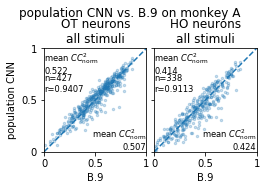

In [20]:
draw_one_stuff()

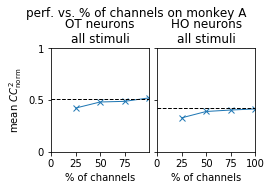

In [21]:
# magic numbers here follow
# https://github.com/leelabcnbc/tang_jcompneuro/blob/master/thesis_plots/v1_fitting/results_glm_opt_detailed.ipynb
def draw_one_stuff_percentage():
    image_subset_and_neuron_subset_list = (('all', 'OT'), ('all', 'HO'))
    num_panel = len(image_subset_and_neuron_subset_list)
    
    plt.close('all')
    fig, axes = plt.subplots(1, num_panel, sharex=False, sharey=True, squeeze=False,
                            figsize=(5.5/3*2,2.5))
    for idx, (ax, (img_subset, neuron_subset)) in enumerate(zip(axes.ravel(), image_subset_and_neuron_subset_list)):
#         data_x = base_perf_dict[neuron_subset]['raw']
        data_x = np.array([25, 50, 75, 100])
        if neuron_subset == 'HO':
            data_y = np.array([HO_perm['score'].loc[f'9_3_{x}', 'poisson_1000'] for x in data_x])
        else:
            assert neuron_subset == 'OT'
            data_y = np.array([OT_perm['score'].loc[f'9_3_{x}', 'poisson_1000'] for x in data_x])
        assert data_x.shape == data_y.shape
        show_perf_vs_size([data_x], [data_y], ['dummy'],
                          title=f'{neuron_subset} neurons\n{img_subset} stimuli',
                      ax=ax, xlabel='% of channels',
                      ylabel='mean $CC_\mathrm{norm}^2$' if idx == 0 else None,
                         style_list=[('-', '#1f77b4', 'x')], show_legend=False,
                         xlim=(0,100),
                         xticks=(0,25,50,75,100) if idx != 0 else (0,25,50,75,),
                         xticklabels=('0', '25', '50', '75', '100') if idx!= 0 else ('0', '25', '50', '75',),
                         hline=base_perf_dict[neuron_subset]['mean'])
    fig.suptitle(f'perf. vs. % of channels on monkey A')
    # adjust figure 
    fig.subplots_adjust(top=0.75, bottom=0.175, left=0.175, right=0.95, hspace=0.1, wspace=0.075)
    
    
    save_dir = os.path.join(dir_dictionary['plots'], 'supp', 'cnn_pop')
    os.makedirs(save_dir, exist_ok=True)
    fig.savefig(os.path.join(save_dir, f'monkeyA_percentage.pdf'), dpi=300)
    
    plt.show()
draw_one_stuff_percentage()